<a href="https://colab.research.google.com/github/allen-del/Learning_PyTorch/blob/main/01.%20PyTorch%20Workflow01/pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pytorch Workflow

End to End Workflow
* data (prepare and load)
* build model
* fit the model (training)
* inference (making predictions and evaulating model)
* saving and loading model
* putting everything together

In [ ]:
import torch
from torch import nn #torch.nn has the basic PyTorch building blocks for neural networks.
import matplotlib.pyplot as plt
torch.__version__

'2.2.1+cu121'

### Data (preparing and loading)

Start with Linear Regression to create a straight line with known parameters

In [ ]:
#Some known parameters (our ideal model should replicate these parameters)
weight = 0.7
bias = 0.3

#Create data (usually we get this from somewhere)
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

###Splitting dataset

Dataset split into 3 and each set has a specific purpose.

* **Training set** - Model learns from this data, `60-80%`
* **Validation set** - Model gets tuned on this data (not used in every case) `10-20%`
* **Test set** - Model gets evaluated on this data to test what it has learned. `10-20%`

In [ ]:
#Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

####Plotting the split

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data, and Predictions.
  """
  plt.figure(figsize=(10,7))

  #Plot training data
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')

  #Plot testing data
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing Data')

  #Are there predictions?
  if predictions is not None:
    #Plot predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  #Show legend
  plt.legend();

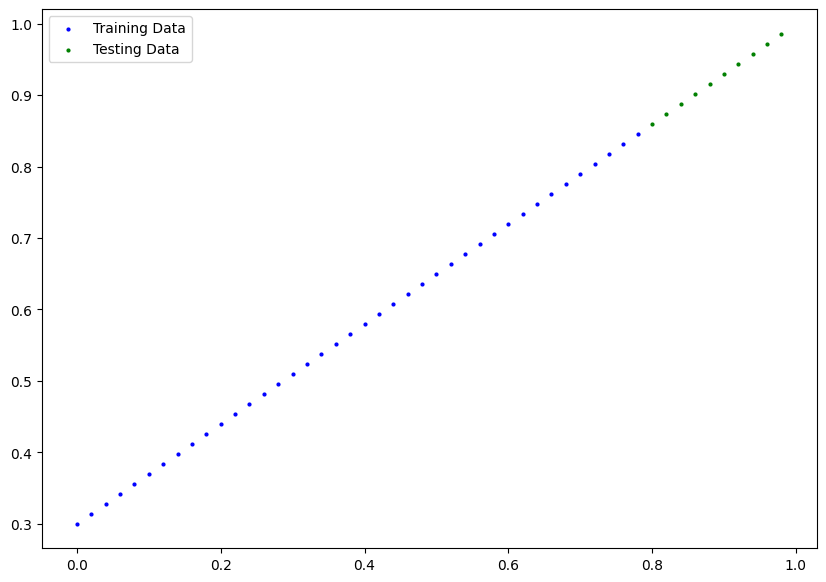

In [ ]:
plot_predictions();

###Building the Model

In [ ]:
#Create linear regression model class

class LinearRegressionModel(nn.Module): #Almost all models inherit from nn.Module
  def __init__(self):
    super().__init__() #https://www.geeksforgeeks.org/python-super-with-__init__-method/

    #Initializing model parameters (start with random values)
    self.weights = nn.Parameter(torch.randn(1, #<- Start with a random value
                                            requires_grad=True, #<- Should be updated with gradient descent. PyTorch will track descent for us with torch.autograd.
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

    #Forward method to define the computation in the model (ANY)
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
      return self.weights*x + self.bias



####PyTorch Model building essentials

* **torch.nn** contains all of the buildings for computational graphs (a neural network can be considered as a computational graph)
* **torch.nn.Parameter** - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.
* **torch.nn.Module** - the base class for all neural network modules. If you subclass it, you should override forward()
* **torch.optim** - for optimizers in PyTorch (helps with gradient descent)
* **forward()** - All nn.Module subclasses require you to overwrite this function. Defines what happens in Forward pass(computation)

####Checking contents of Model

In [ ]:
torch.manual_seed(42)

#Create an instance of the model
model_0 = LinearRegressionModel()

#Check out the parameters
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
#List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
###Making predictions
with torch.inference_mode(): #inference mode disables gradient tracking (which is not needed unless training which means code is faster)
  y_preds = model_0(X_test)

y_preds, y_test

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

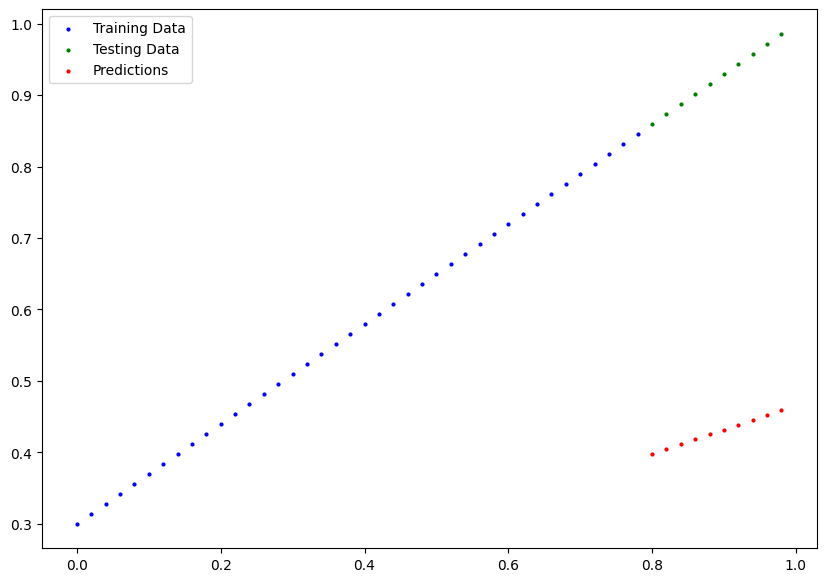

In [ ]:
plot_predictions(predictions=y_preds)

### Training Model

We go from unknown (or random) parameters to known parameters(ideal outputs)

Things we need to train:

* **Loss function**: A function to measure how wrong your models predictions are w.r.t the ideal outputs. Lower value is better

* **Optimizer**: Takes into account the loss of a model and adjusts model parameters(eg. weight and bias) to improve(lower) loss function values.

Specifically for PyTorch we need

* a training loop
* a testing loop

In [ ]:
#Setup loss function

loss_fn = nn.L1Loss() #L1 is  Mean Absolute Error

#Setup an optimizer(We're using Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)#Learning rate-(we set it ourselves) aka How big of a step in Gradient descent



#### Building a training loop and testing loop


Steps:
0. Loop through the data
1. Forward Pass/Propagation (data moves throughour model's `forward()`)
2. Calculate loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. **Backpropagation**/Loss backward - move backwards through network to calculate the gradients of each parameter of our model w.r.t to loss.                           
5. Optimizer step - use optimizer to adjust model params to minimize loss (**gradient descent**)

In [ ]:
torch.manual_seed(42)


epochs = 250 #Single loop through data..(hyperparameter)



#Tracking experiment values
epoch_count= []
loss_values=[]
test_loss_values=[]


#Training Loop (works and learns from training data)

for epoch in range(epochs):
  model_0.train() #set model to train mode. gradient tracking is ON-sets all parameters that require gradients to require gradients.

  y_pred = model_0(X_train)

  loss = loss_fn(y_pred, y_train)
  #print(f"Training Loss: {loss}")

  optimizer.zero_grad() #Prevents accumulation of gradients during backpropagation step. Read more : https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

  loss.backward() #Backpropagation on loss function

  optimizer.step() #Performs gradient descent


  #Testing code (works with Test data)

  model_0.eval() #evaluate/ testing mode turns off setting not needed for testing

  with torch.inference_mode(): #turns off gradient tracking & some other things behind scenes.

    test_pred = model_0(X_test) #Forward pass

    test_loss = loss_fn(test_pred, y_test) #Calculate Loss

    if epoch%10==0:

      epoch_count.append(epoch)
      loss_values.append(loss.detach())
      test_loss_values.append(test_loss)

      print(f"{epoch} Epochs | Loss:{loss} | Test Loss:{test_loss} | Parameters: {model_0.state_dict()}")



0 Epochs | Loss:0.31288138031959534 | Test Loss:0.48106518387794495 | Parameters: OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
10 Epochs | Loss:0.1976713240146637 | Test Loss:0.3463551998138428 | Parameters: OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
20 Epochs | Loss:0.08908725529909134 | Test Loss:0.21729660034179688 | Parameters: OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
30 Epochs | Loss:0.053148526698350906 | Test Loss:0.14464017748832703 | Parameters: OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
40 Epochs | Loss:0.04543796554207802 | Test Loss:0.11360953003168106 | Parameters: OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
50 Epochs | Loss:0.04167863354086876 | Test Loss:0.09919948130846024 | Parameters: OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
60 Epochs | Loss:0.03818932920694351 | Test Loss:0.088866330683231

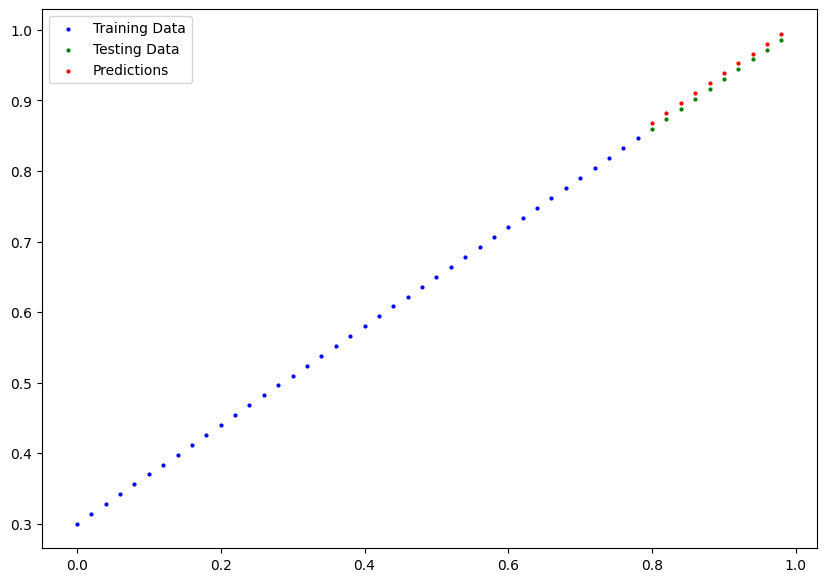

In [ ]:
plot_predictions(predictions = test_pred)

####Plotting loss curves

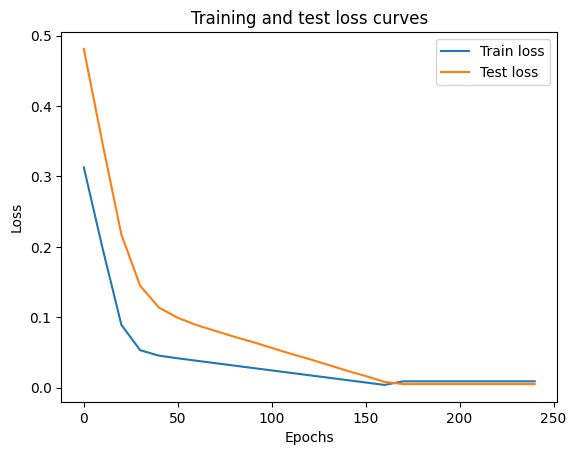

In [ ]:
plt.plot(epoch_count, loss_values, label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();

###Saving and Loading the trained model

There are 3 main methods to save and load models

* `torch.save()` - saves PyTorch object in Pythons's pickle format
* `torch.load()` - loads a saved Pytorch object

* `torch.nn.Module.load_state_dict()` - allows us to load a models saved dictionary of parameters

In [ ]:
#Saving our PyTorch model
from pathlib import Path

#1. Create models directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path

MODEL_NAME = "01_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH


PosixPath('models/01_model_0.pth')

In [ ]:
#Save model state dict

torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)





In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
#To test load() we instantiate a new instance of our model class LinearRegressionModel

torch.manual_seed(60)

loaded_model_0 = LinearRegressionModel()
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.7534])), ('bias', tensor([1.8541]))])

In [ ]:
#Load the saved parameters to new model

loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
#Check predictions of the loaded model and compare to original model

loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

#plot_predictions(predictions=loaded_model_preds)


model_0.eval()

with torch.inference_mode():
  OG_model_preds = model_0(X_test)

#plot_predictions(predictions=OG_model_preds)

print(OG_model_preds==loaded_model_preds)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


##Putting everything together

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

Create device agnostic code. Uses GPU if available for faster computation.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
!nvidia-smi

Sun May 19 11:36:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              28W /  70W |    159MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

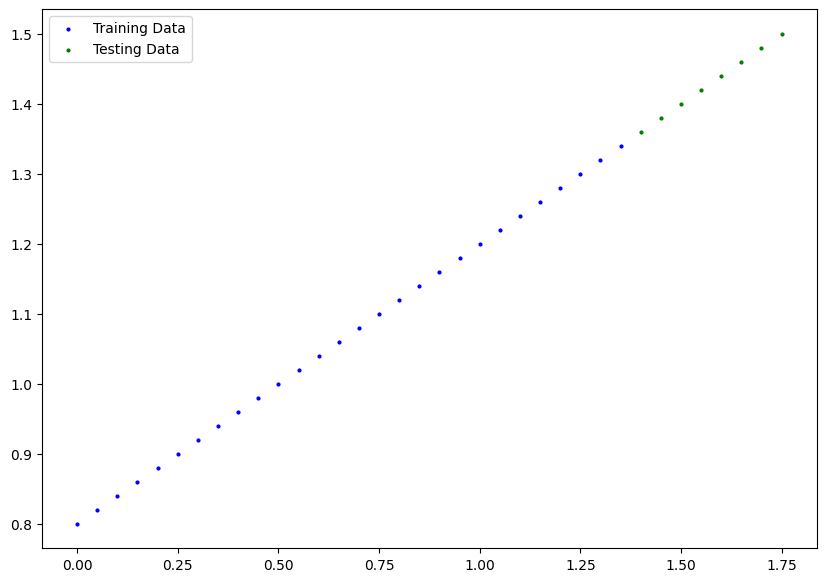

In [ ]:
weight = 0.4
bias = 0.8

start = 0
end = 1.8
step = 0.05

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]



def plot_predictions(train_data = X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data, and Predictions.
  """
  plt.figure(figsize=(10,7))

  #Plot training data
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training Data')

  #Plot testing data
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing Data')

  #Are there predictions?
  if predictions is not None:
    #Plot predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  #Show legend
  plt.legend();


plot_predictions(X_train, y_train, X_test, y_test)

In [ ]:
#Creating a model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    #Use nn.Linear() for initializing model parameters(aka: linear transforms/dense layer, probing layer, fully connected layer)
    self.linear_layer = nn.Linear(in_features=1,out_features=1) #how many features are going into the model and what the model outputs

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

#Creating instance of model

torch.manual_seed(42)

model_1=LinearRegressionModelV2()
model_1.state_dict()


OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [ ]:
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
lossfn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.001)

In [ ]:
#Training loop

torch.manual_seed(42)

#Write device agnostic code (Put the model and tensors into your GPU)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)



epochs=1200

epoch_count=[]
train_loss=[]
test_loss=[]

for epoch in range(epochs):

  model_1.train()

  y_pred = model_1(X_train)

  training_loss = lossfn(y_pred, y_train)

  optimizer.zero_grad()

  training_loss.backward()

  optimizer.step()


  model_1.eval()

  with torch.inference_mode():

    test_pred = model_1(X_test)

    testing_loss = lossfn(test_pred, y_test)

    epoch_count.append(epoch)
    train_loss.append(training_loss.detach().cpu())
    test_loss.append(testing_loss.cpu())

    if epoch%50 == 0:

      print(f"{epoch} Epochs|| Train Loss:{training_loss} || Test Loss:{testing_loss}")




0 Epochs|| Train Loss:0.2760714292526245 || Test Loss:0.6020928621292114
50 Epochs|| Train Loss:0.20625479519367218 || Test Loss:0.5005949139595032
100 Epochs|| Train Loss:0.15325766801834106 || Test Loss:0.4092574715614319
150 Epochs|| Train Loss:0.11614328622817993 || Test Loss:0.3307274580001831
200 Epochs|| Train Loss:0.09159601479768753 || Test Loss:0.265936017036438
250 Epochs|| Train Loss:0.07670331001281738 || Test Loss:0.21578188240528107
300 Epochs|| Train Loss:0.0675252377986908 || Test Loss:0.17821338772773743
350 Epochs|| Train Loss:0.0615789033472538 || Test Loss:0.15200813114643097
400 Epochs|| Train Loss:0.056841351091861725 || Test Loss:0.13226595520973206
450 Epochs|| Train Loss:0.0527847595512867 || Test Loss:0.12000516057014465
500 Epochs|| Train Loss:0.048728179186582565 || Test Loss:0.10774430632591248
550 Epochs|| Train Loss:0.04467932879924774 || Test Loss:0.09580618143081665
600 Epochs|| Train Loss:0.040711771696805954 || Test Loss:0.08725617825984955
650 Epoch

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4001]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.7997], device='cuda:0'))])

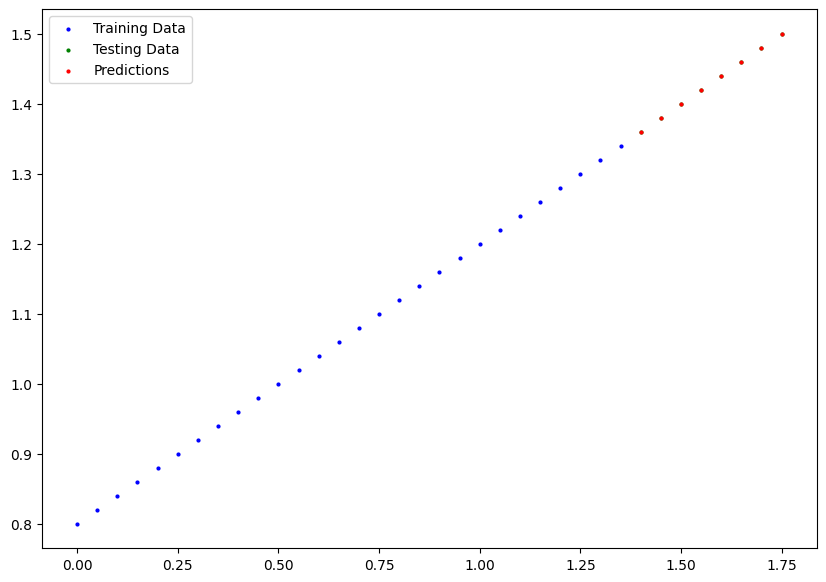

In [ ]:
plot_predictions(predictions = test_pred.cpu())

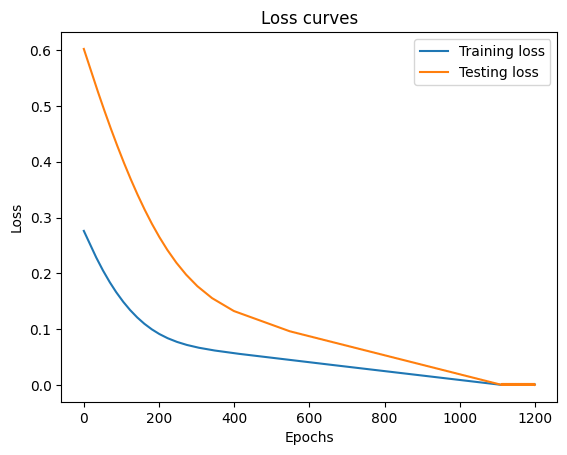

In [ ]:
plt.plot(epoch_count, train_loss, label="Training loss")
plt.plot(epoch_count, test_loss, label="Testing loss" )
plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [ ]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving to {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving to models/01_model_1.pth


In [ ]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
test_pred == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')